# Transformer: All You Need Is Attention

A simple implementation of a BERT-like transformer architecture in Knet/NNHelferlein-style following the iconic *Vaswani, 2017* transformer (fig. from *Vaswani et al. NIPS (2017)* http://arxiv.org/abs/1706.03762 ):

<img src="assets/80-vaswani-fig-1.png" width="400">

In [1]:
using Knet, NNHelferlein
using LinearAlgebra

┌ Info: Precompiling NNHelferlein [b9e938e5-d80d-48a2-bb0e-6649b4a98aeb]
└ @ Base loading.jl:1423


### Helpers

Tools for masking, positional encoding and multi-headed dot-product-attention are used from *NNHelferlein*:

In [2]:
mk_peek_ahead_mask(rand(10,2))

10×10 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0

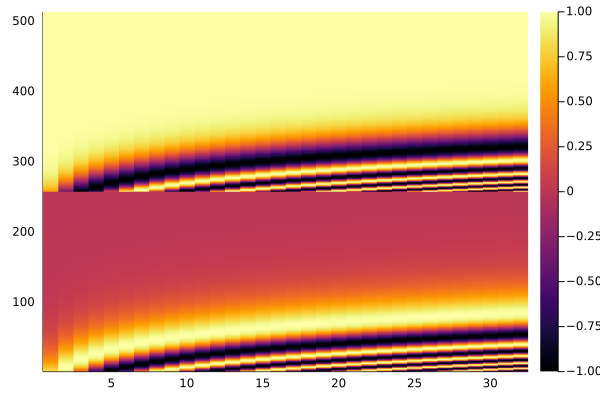

In [4]:
using Plots
heatmap(Array(positional_encoding_sincos(512, 32)))

... the self-attention looks like expected:

In [5]:
m = mk_peek_ahead_mask(zeros(16,64))
x = convert2CuArray(randn(1024, 16, 64))
c,α = dot_prod_attn(x,x,x, mask=m)
@show size(c)   # context
@show size(α);  # attention factors

size(c) = (1024, 16, 64)
size(α) = (16, 16, 64)


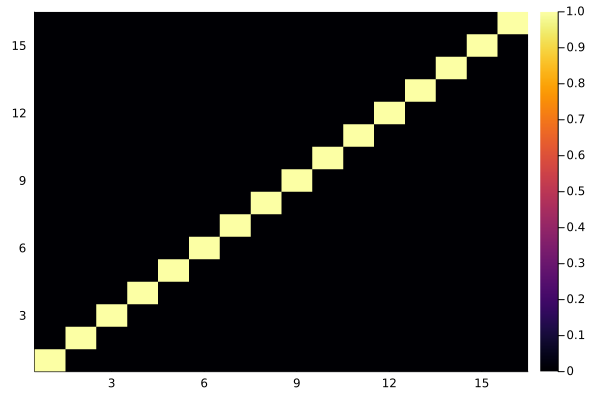

In [6]:
heatmap(Array(α[:,:,1])) 

... multi-headed self-attention generates a stack of attention martrices; here: 
+ 8 heads
+ embedding depth 512
+ sequence length 16

results in 8 16x16 matrices for each of the 64 sequences of the minibatch:

In [7]:
mha = MultiHeadAttn(512, 8)
x = convert2CuArray(randn(Float32, 512, 16, 64))   # [depth, seq_len, mb_size]
c,α = mha(x,x,x)                                  
@show size(α);

size(α) = (16, 16, 8, 64)


## Encoder:
The encoder is built as list of Encoder layers. Each layer performs a multi-headed self-attention. Resiual connections are added to bypass the layers and secured by layer normalisation.

The complete Encoder executes all layers after embedding, positional encoding and mask generation:

In [8]:
mutable struct EncoderLayer
    mha           # multi-head attn
    drop1
    norm1         # layer-norm
    ffwd1; ffwd2  # final feed forward 4*depth
    drop2
    norm2

    EncoderLayer(depth, n_heads, drop) = new(MultiHeadAttn(depth, n_heads),
                                                Dropout(drop),
                                                LayerNorm(depth),
                                                Linear(depth, depth*4, actf=relu),
                                                Linear(depth*4, depth),
                                                Dropout(drop),
                                                LayerNorm(depth)
                                                )
    end

function (el::EncoderLayer)(x; mask=nothing)

    c, α = el.mha(x, x, x, mask=mask)   # always: [depth, seq_len, mb_size]
    c = el.drop1(c)
    o1 = el.norm1(x .+ c)

    o2 = el.ffwd1(o1)                   # [depth*4, seq_len, mb_size]
    o2 = el.ffwd2(o2)                   # back: [depth, seq_len, mb_size]
    o2 = el.drop2(o2)
    o2 = el.norm2(o1 .+ o2)
    return o2, α
end

In [9]:
mutable struct Encoder
    depth          # embeding depth
    embed          # embedding layer
    pad_id         # id of padding word
    n_layers
    layers         # list of actual encoder layers
    drop           # dropout layer

    Encoder(n_layers, depth, n_heads, vocab_size; pad_id=NNHelferlein.TOKEN_PAD, drop_rate=0.1) =
            new(depth,
                Embed(vocab_size, depth),
                pad_id,
                n_layers,
                [EncoderLayer(depth, n_heads, drop_rate) for i in 1:n_layers],
                Dropout(drop_rate))
end


function (e::Encoder)(x)

    n_seq = size(x)[1]
    m_pad = mk_padding_mask(x, pad=e.pad_id, add_dims=true)
    x = e.embed(x)                                          # [depth, seq_len, mb_size]
    x = x .+ positional_encoding_sincos(e.depth, n_seq)
    x = e.drop(x)

    for l in e.layers
        x,α = l(x, mask=m_pad)
    end
    return x
end

Output of the encoder is the encoder hidden state with the same size as the input after embedding
\[*embedding, seq_len, mb_size*\] (here: embedding depth: 1024, 5 encoder layers, 4 heads and a vocab size of 20000):

In [10]:
mbx = rand(1:20000, 16, 64)
e = Encoder(5, 1024, 4, 20000)
henc = e(mbx)
@show size(henc);

size(henc) = (1024, 16, 64)


## Decoder

Decoder layout follows the Encoder and is build from Decoder Layers. The layers are similar to 
the Encoder Layers with the difference that after the self-attention an attention to the encoder state is added:

In [11]:
mutable struct DecoderLayer
    mhsa          # multi-head attn
    drop1
    norm1         # layer-norm
    mha
    drop2
    norm2
    ffwd1; ffwd2  # final feed forward
    drop3
    norm3

    DecoderLayer(depth, n_heads; drop_rate=0.1) = new(MultiHeadAttn(depth, n_heads),
                                             Dropout(drop_rate),
                                             LayerNorm(depth),
                                             MultiHeadAttn(depth, n_heads),
                                             Dropout(drop_rate),
                                             LayerNorm(depth),
                                             Linear(depth, depth*4, actf=relu),
                                             Linear(depth*4, depth),
                                             Dropout(drop_rate),
                                             LayerNorm(depth)
                                             )
    end

function (dec::DecoderLayer)(x, h_encoder; enc_m_pad=nothing, m_combi=nothing)

    self_c, α1 = dec.mhsa(x, x, x, mask=m_combi)    # c: [depth, seq_len, mb_size]
                                                    # α: [seq1_len, seq2_len, n_heads, mb_size]
    self_c = dec.drop1(self_c)
    self_c = dec.norm1(x .+ self_c)

    o1, α2 = dec.mha(self_c, h_encoder, h_encoder, mask=enc_m_pad)
    o1 = dec.drop2(o1)
    o1 = dec.norm2(o1 .+ self_c)

    o2 = dec.ffwd1(o1)
    o2 = dec.ffwd2(o2)
    o2 = dec.drop2(o2)
    o2 = dec.norm2(o1 + o2)
    return o2, α1, α2
end

In [12]:
mutable struct Decoder
    depth          # embeding depth
    embed          # embedding layer
    pad_id
    n_layers
    layers         # list of actual encoder layers
    drop           # dropout layer

    Decoder(n_layers, depth, n_heads, vocab_size; pad_id=NNHelferlein.TOKEN_PAD, drop_rate=0.1) =
            new(depth,
                Embed(vocab_size, depth),
                pad_id,
                n_layers,
                [DecoderLayer(depth, n_heads, drop_rate=drop_rate) for i in 1:n_layers],
                Dropout(drop_rate))
end

function (d::Decoder)(y, h_enc; enc_m_pad=nothing)

    n_seq = size(y)[1]
    m_peek = mk_peek_ahead_mask(y)                           
    m_pad = mk_padding_mask(y, pad=d.pad_id, add_dims=true)  
    m_combi = max.(m_peek, m_pad)                            # combined target sequence mask needed
                                                             # for self-attn
    y = d.embed(y)                                           # [depth, seq_len, mb_size]
    y = y .+ positional_encoding_sincos(d.depth, n_seq)
    y = d.drop(y)

    α2 = init0(0,0,0)
    for l in d.layers
        y,α1,α2 = l(y, h_enc, enc_m_pad=enc_m_pad, m_combi=m_combi)
    end
    return y, α2
end

... test output shapes with random data:

In [13]:
mbx = rand(1:20000, 16, 64)
e = Encoder(5, 1024, 4, 20000)
henc = e(mbx)
@show size(henc);

size(henc) = (1024, 16, 64)


In [14]:
mby = rand(1:20000, 16, 64)
d = Decoder(5, 1024, 4, 20000)
p,α = d(mby, henc)
@show size(p)
@show size(α);

size(p) = (1024, 16, 64)
size(α) = (16, 16, 4, 64)


## Transformer:

The transformer is easily built from the Encoder and Decoder types 
by calling the  Encoder to generate the encoder hidden state 
and calling the Decoder to generate the output.
A final dense layer (*predict*) is added to restore the result vector of vocabular length 
from the embedding.

This transformer always generates output sequences of the same length as the decoder input sequence.

In [15]:
mutable struct Transformer
    encoder
    decoder
    predict
    n_layers
    depth
    n_heads
    x_vocab
    y_vocab
    drop_rate

    Transformer(;n_layers=6, depth=512, n_heads=8,
                    x_vocab=nothing, y_vocab=nothing, drop_rate=0.1) = new(
                    Encoder(n_layers, depth, n_heads, x_vocab.len, pad_id=TOKEN_PAD, drop_rate=drop_rate),
                    Decoder(n_layers, depth, n_heads, y_vocab.len, pad_id=TOKEN_PAD, drop_rate=drop_rate),
                    Linear(depth, y_vocab.len),
                    n_layers, depth, n_heads, x_vocab, y_vocab, drop_rate
                    )
end

function (tf::Transformer)(x, y)

    enc_state = tf.encoder(x)                                        # [depth, seq_len, mb_size]
    enc_mask = mk_padding_mask(x, add_dims=true)

    dec_state, α2 = tf.decoder(y, enc_state, enc_m_pad=enc_mask)     # [depth, seq_len, mb_size]
    out = tf.predict(dec_state)                                      # [y_vocab_len, seq_len, mb_size]
    return out, α2
end

## Playground data

For first experiments a tiny but endearing dataset is used and prepared with *NNHelferlein* tools:

In [66]:
de = ["Ich liebe Julia",
      "Peter liebt Python",
      "Susi liebt alle",
      "Ich programmiere immer in Julia"]
en = ["I love Julia",
      "Peter loves Python",
      "Susi loves them all",
      "I always code Julia"]

de_vocab = WordTokenizer(de)
d = de_vocab(de, add_ctls=true)
d = pad_sequence.(d, 8)
d = truncate_sequence.(d, 8)

4-element Vector{Vector{Int32}}:
 [1, 7, 9, 6, 2, 3, 3, 3]
 [1, 10, 5, 13, 2, 3, 3, 3]
 [1, 15, 5, 11, 2, 3, 3, 3]
 [1, 7, 12, 8, 14, 6, 2, 3]

In [67]:
en_vocab = WordTokenizer(en)
e = en_vocab(en, add_ctls=true)
e = pad_sequence.(e, 8)
e = truncate_sequence.(e, 8)

4-element Vector{Vector{Int32}}:
 [1, 7, 10, 5, 2, 3, 3, 3]
 [1, 9, 6, 11, 2, 3, 3, 3]
 [1, 12, 6, 14, 13, 2, 3, 3]
 [1, 7, 15, 8, 5, 2, 3, 3]

In [68]:
mbs = sequence_minibatch(d, e, 2)
x,y = first(mbs)
@show length(mbs)
@show x
@show y;

length(mbs) = 2
x = Int32[1 1; 7 10; 9 5; 6 13; 2 2; 3 3; 3 3; 3 3]
y = Int32[1 1; 7 9; 10 6; 5 11; 2 2; 3 3; 3 3; 3 3]


The transformer generates output sequences of the same length as the decoder input (here: 8).

Each output vector (i.e. 1st dimension) has the length of the vocab size; the maximum value marks
the prediction (not here, because the model is not yet trained!); this can be done with the *NNHelferlein* function `de_embed()` and the tokeniser can be used to back-transform the tokens into words:

In [69]:
tf = Transformer(n_layers=5, depth=128, n_heads=4, 
        x_vocab=de_vocab, y_vocab=en_vocab)
o,α = tf(x,y)
@show size(o);

size(o) = (15, 8, 2)


In [70]:
p = de_embed(o)   # actually argmax() on the first dimension

1×8×2 Array{Int64, 3}:
[:, :, 1] =
 2  2  2  2  2  2  2  2

[:, :, 2] =
 2  2  2  2  2  2  2  2

In [21]:
en_vocab(p[:,:,1])   # the tokeniser can be used for de-tokenisation as well

"<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>"

# Final model - All You Need is Attention

A last model and signature is necessary for training by computing the loss for *(x,y)*-pairs:

In [22]:

mutable struct AllYouNeed
    tf # this is the transformer
    depth
    n_heads
    x_vocab
    y_vocab
    drop_rate
    AllYouNeed(;n_layers=6, depth=512, n_heads=8,
                x_vocab=nothing, y_vocab=nothing, drop_rate=0.1) = new(
                    Transformer(n_layers=n_layers, depth=depth,
                                n_heads=n_heads,
                                x_vocab=x_vocab, y_vocab=y_vocab,
                                drop_rate=drop_rate),
                    depth, n_heads,
                    x_vocab, y_vocab, drop_rate)
end

function (ayn::AllYouNeed)(x, y)

    # 1st: make shifted y for in and out:
    #
    y_in = y[1:end-1,:]
    y_teach = y[2:end,:]

    o, α = ayn.tf(x, y_in)

    # calc crossentropy loss (nll) only from positions not masked:
    #
    mask = y_teach .!= NNHelferlein.TOKEN_PAD
    y_m = y_teach .* mask
    loss = nll(o, y_m, average=true)
    return loss
end

function (ayn::AllYouNeed)(data::Tuple)
    return ayn(data[1], data[2])
end

In [23]:
ayn = AllYouNeed(n_layers=5, depth=128, n_heads=4, 
        x_vocab=de_vocab, y_vocab=en_vocab)

ayn(x,y)

3.660651f0

## Accuracy:

In order to monitor the training an accuracy meassure is needed. *NNHelferlein* provides an 
accuracy for sequences, based on their *Hamming* distance (`hamming_acc()`). 
However, the default signature of accuracy functions (to be used with `tb_train()`) 
assumes that a prediction for a model `mdl`
can be obtained by calling `y = mdl(x)`, which is not possible for the transformer, because 
a decoder input sequence is always necessary to be transformed.
Therefore a wrapper must be defined to provide the demanded signature:

In [24]:
function train_acc(mdl; data=nothing)

    tac = Float32(0.0)
    for (x,y) in data
        y_in = y[1:end-1,:]
        y_teach = y[2:end,:]
        o, α = mdl.tf(x, y_in)

        p = de_embed(o, remove_dim=true)
        tac += hamming_acc(p, y_teach, vocab=mdl.y_vocab)
    end

    return tac / length(data)
end

train_acc (generic function with 1 method)

In [25]:
train_acc(ayn, data=mbs)

0.14583333333333331

# Training:
The training of the transformen should be started with a warmup-phase with a very small 
learning rate. The warmup can be performed as a separate training with a "lerning-rate decay"
that starts with a small and ends with a larger rate (this is actually not a 
*decay* but a rather an increase):

In [71]:
mbs = sequence_minibatch(d, e, 2)

ayn = AllYouNeed(n_layers=4, depth=128, n_heads=2,
                x_vocab=de_vocab, y_vocab=en_vocab, drop_rate=0.1)

ayn = tb_train!(ayn, Adam, mbs, epochs=100,
                lr=1e-9, lr_decay=2e-4, lrd_steps=5, lrd_linear=true,
                tb_name="I_love_WARMUP",
                acc_fun=train_acc, eval_size=1, eval_freq=1)
ayn = tb_train!(ayn, Adam, mbs, epochs=150,
                lr=1e-4, lr_decay=1e-5, lrd_steps=5, lrd_linear=true,
                tb_name="I_love_TRAIN",
                acc_fun=train_acc, eval_size=1, eval_freq=1);

Training 100 epochs with 2 minibatches/epoch.
Evaluation is performed every 2 minibatches with 2 mbs.
Watch the progress with TensorBoard at:
/data/aNN/Helferlein/logs/I_love_WARMUP/2022-04-04T06-53-28


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


Setting learning rate to η=5.00e-05 in epoch 20.5
Setting learning rate to η=1.00e-04 in epoch 40.5
Setting learning rate to η=1.50e-04 in epoch 60.5
Setting learning rate to η=2.00e-04 in epoch 80.5
Training finished with:
Training loss:       0.7795718908309937
Training accuracy:   0.8125
Training 150 epochs with 2 minibatches/epoch.
Evaluation is performed every 2 minibatches with 2 mbs.
Watch the progress with TensorBoard at:
/data/aNN/Helferlein/logs/I_love_TRAIN/2022-04-04T06-53-48


Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


Setting learning rate to η=7.75e-05 in epoch 30.5
Setting learning rate to η=5.50e-05 in epoch 60.5
Setting learning rate to η=3.25e-05 in epoch 90.5
Setting learning rate to η=1.00e-05 in epoch 120.5
Training finished with:
Training loss:       0.03347751032561064
Training accuracy:   1.0


The Tensorboard-log; Loss:

<img src="assets/80-tb-log-mbs.png" width="800">

and training-/validation accuracy:

<img src="assets/80-tb-logs-acc.png" width="800">

## Manual evaluation of the playground data:

In order to see how the transformer works, let's run one sequence/sentence 
step by step trougth the transformer:

In [72]:
x = reshape(ayn.x_vocab("Ich liebe Julia", add_ctls=true, split_words=true), :,1)

5×1 Matrix{Int32}:
 1
 7
 9
 6
 2

In [73]:
start = reshape([ayn.y_vocab("<start>")], 1,1)
y = start

1×1 Matrix{Int32}:
 1

The following cell must be executed several times to simulate the prediction loop. 
Every round will generate one more word:

In [77]:
o, α = ayn.tf(x,y)
p = de_embed(o, remove_dim=true)
y = vcat(start, p)
ayn.y_vocab(p)

"I love Julia <end>"

## A signature to run predict

This predict loop can be run until the `<end>`-token is generated.
The loop starts with sequence length 1 by transformint a `<start>`-token 
in context of the encoder state.

Each generated output is extended by adding the `<start>`-token and
transformed again, until `<end>` is detected.

The signature with an `AbstractString` as input can be used to directly
translate a sentence:

In [30]:
function (ayn::AllYouNeed)(x)

    n_seq = length(x)
    x = reshape(x, :,1)
    START = ayn.y_vocab("<start>")
    END = ayn.y_vocab("<end>")
    PAD = ayn.y_vocab("<pad>")

    start = reshape([START], 1,1)   # make minibatch 2-d-array
    y = copy(start)

    max_len = 2n_seq                # restrict maximum output len to 2*length of x
    i = 1
    while (y[end,1] != END) && i <= max_len

        out,α = ayn.tf(x,y)
        p = de_embed(out, remove_dim=true)
        y = vcat(start, p)
        i += 1
    end
    return y
end

function (ayn::AllYouNeed)(s::AbstractString; alpha=false)

    x = ayn.x_vocab(s, split_words=true, add_ctls=true)
    p = ayn(x)
    return ayn.y_vocab(p)
end

In [31]:
ayn("Ich liebe Julia")

"<start> I love Julia <end>"

In [32]:
ayn("Peter liebt Python")

"<start> Peter loves Python <end>"

# Test with a more realistic dataset:

Datasets for training translators are not easy to find. A good choice are the corpi 
provided by Tatoeba with n\*100000 sentences for some language pairs.
However, even these corpi are very limited; sufficient for proof-of-concept but 
not for produtive applications.

*NNHelferlein* provides access to the datasets. Here, the 250000 German-English sentence pairs
are downloaded and tuncated or padded to a length of 16 (including `<start>` and `<end>` tokens):

In [33]:
en,de = get_tatoeba_corpus("deu")
en = en[20000:end]           # remove sentences with 1 or 2 words
de = de[20000:end];

dir = normpath(joinpath(dirname(pathof(#= /root/.julia/packages/NNHelferlein/DOQwR/src/texts.jl:314 =# @__MODULE__())), "..", "data", "Tatoeba")) = "/root/.julia/packages/NNHelferlein/DOQwR/data/Tatoeba"
pathname = joinpath(dir, fname) = "/root/.julia/packages/NNHelferlein/DOQwR/data/Tatoeba/deu-eng.zip"
Corpus for language deu is already downloaded.
Reading Tatoeba corpus for languages en-deu

importing sentences: 249000

In [34]:
de_vocab = WordTokenizer(de)
d = de_vocab(de, add_ctls=true)
d = pad_sequence.(d, 16)
d = truncate_sequence.(d, 16)

en_vocab = WordTokenizer(en)
e = en_vocab(en, add_ctls=true)
e = pad_sequence.(e, 16)
e = truncate_sequence.(e, 16);

The training is performed with minibatches of size 128, with a warmup phase and 
a learning rate starting at 1e-9.

Training and validation accurracy and loss are calculated during training after each epoch 
and only with 1% of the data (this speeds up training; 
the training curves might become somewhat zigzag as a result).

In [35]:
mbs = sequence_minibatch(d, e, 128, shuffle=true);

In [36]:
ayn = AllYouNeed(n_layers=6, depth=256, n_heads=8,
                x_vocab=de_vocab, y_vocab=en_vocab, drop_rate=0.1)

GC.gc()
ayn = tb_train!(ayn, Adam, mbs, epochs=30, split=0.9,
                lr=1e-9, lr_decay=2e-4, lrd_steps=5, lrd_linear=true,
#                beta2=0.98, eps=1e-9,
                tb_name="tatoeba_WARMUP",
                acc_fun=train_acc, eval_size=0.01, eval_freq=1
                )
GC.gc()
ayn = tb_train!(ayn, Adam, mbs, epochs=60, split=0.9,
                lr=1e-4, lr_decay=1e-5, lrd_steps=5,
#                beta2=0.98, eps=1e-9,
                tb_name="tatoeba_TRAIN",
                acc_fun=train_acc, eval_size=0.01, eval_freq=1,
                cp_freq=5
                );

Splitting dataset for training (90%) and validation (10%).
Training 30 epochs with 1611 minibatches/epoch and 179 validation mbs.
Evaluation is performed every 1611 minibatches with 2 mbs.
Watch the progress with TensorBoard at:
/data/aNN/Helferlein/logs/tatoeba_WARMUP/2022-04-03T16-22-59


Progress: 100%|█████████████████████████████████████████| Time: 1:49:19


Setting learning rate to η=5.00e-05 in epoch 6.0
Setting learning rate to η=1.00e-04 in epoch 12.0
Setting learning rate to η=1.50e-04 in epoch 18.0
Setting learning rate to η=2.00e-04 in epoch 24.0
Training finished with:
Training loss:       0.9622708159174556
Training accuracy:   0.7524227723097118
Validation loss:     0.9684001774261783
Validation accuracy: 0.7470889747477394
Splitting dataset for training (90%) and validation (10%).
Training 60 epochs with 1611 minibatches/epoch and 179 validation mbs.
Evaluation is performed every 1611 minibatches with 2 mbs.
Watch the progress with TensorBoard at:
/data/aNN/Helferlein/logs/tatoeba_TRAIN/2022-04-03T18-46-03


Progress: 100%|█████████████████████████████████████████| Time: 5:23:02


Setting learning rate to η=5.62e-05 in epoch 12.0
Setting learning rate to η=3.16e-05 in epoch 24.0
Setting learning rate to η=1.78e-05 in epoch 36.0
Setting learning rate to η=1.00e-05 in epoch 48.0
Training finished with:
Training loss:       0.15835840533436046
Training accuracy:   0.9454670700536262
Validation loss:     0.15705443770942076
Validation accuracy: 0.9415936194086587


In [51]:
# using JLD2
# jldsave("allyouneed.jld2"; ayn)

## Evaluation:
#### Sentences from the training data:

**deu:** "Ich höre immer gerne klassische Musik in meiner Freizeit"    
**eng:** "I always enjoy listening to classical music when I have some free time"    
and: "I always enjoy listening to classical music in my free time"

In [37]:
ayn("Ich höre immer gerne klassische Musik in meiner Freizeit")

"<start> I always enjoy listening to classical music in my spare time <end>"

**deu:** "Tom singt gerne in der Badewanne"    
**eng:** "Tom likes to sing in the bathtub"    

In [38]:
ayn("Tom singt gerne in der Badewanne")

"<start> Tom likes to sing in the bathtub <end>"

#### Sentences that are *not* in the training data:

In [39]:
ayn("Ich höre immer gerne klassische Musik im Auto")

"<start> I always like to listen to classical music in the car <end>"

In [40]:
ayn("Tom hört immer gerne klassische Musik im Auto")

"<start> Tom always likes to listen to classical music in the car <end>"

In [41]:
ayn("Tom singt gerne im Auto")

"<start> Tom likes to sing in the car <end>"

In [42]:
ayn("Meine Tante trägt ein grünes Kleid im Auto")

"<start> My aunt wears a green dress in the car <end>"

In [43]:
ayn("Mein Hund fährt das Auto in die Garage")

"<start> My dog is driving the car into the garage <end>"

In [44]:
ayn("Mein Chef trinkt gerne Kaffee")

"<start> My boss likes coffee <end>"

In [47]:
ayn("Ich möchte diesen Teppich nicht kaufen")

"<start> I don t want to buy this carpet <end>"

In [48]:
ayn("ich gehe jetzt ins Büro")

"<start> I m going to the office now <end>"

In [65]:
ayn("Dieses Ding funktioniert erstaunlich gut")

"<start> This kind of works is excellent <end>"